### Given the log-returns of a stock share X in 1000 consecutive days, let's come up with an optimal [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) model which can forecast the unseen data points the best, that's with minimal error.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.print_version import show_versions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
show_versions()


INSTALLED VERSIONS
------------------
Python: 3.10.13.final.0
OS: Darwin 23.2.0 Darwin Kernel Version 23.2.0: Wed Nov 15 21:53:18 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T6000 arm64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.14.1 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/statsmodels)

Required Dependencies

cython: 3.0.8 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/Cython)
numpy: 1.26.3 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/numpy)
scipy: 1.11.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/scipy)
pandas: 2.1.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pandas)
    dateutil: 2.8.2 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/dateutil)
patsy: 0.5.6 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pats

In [3]:
returns = pd.read_csv('returns.txt', header=None).squeeze()
returns.index = pd.date_range('1/1/2000', periods=len(returns), freq='D')
returns.name = 'returns'

returns.head()

2000-01-01   -0.000085
2000-01-02    0.000093
2000-01-03    0.000026
2000-01-04    0.000034
2000-01-05   -0.000077
Freq: D, Name: returns, dtype: float64

### As one can see from the [STL plot](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html) below the data is pretty noisy.

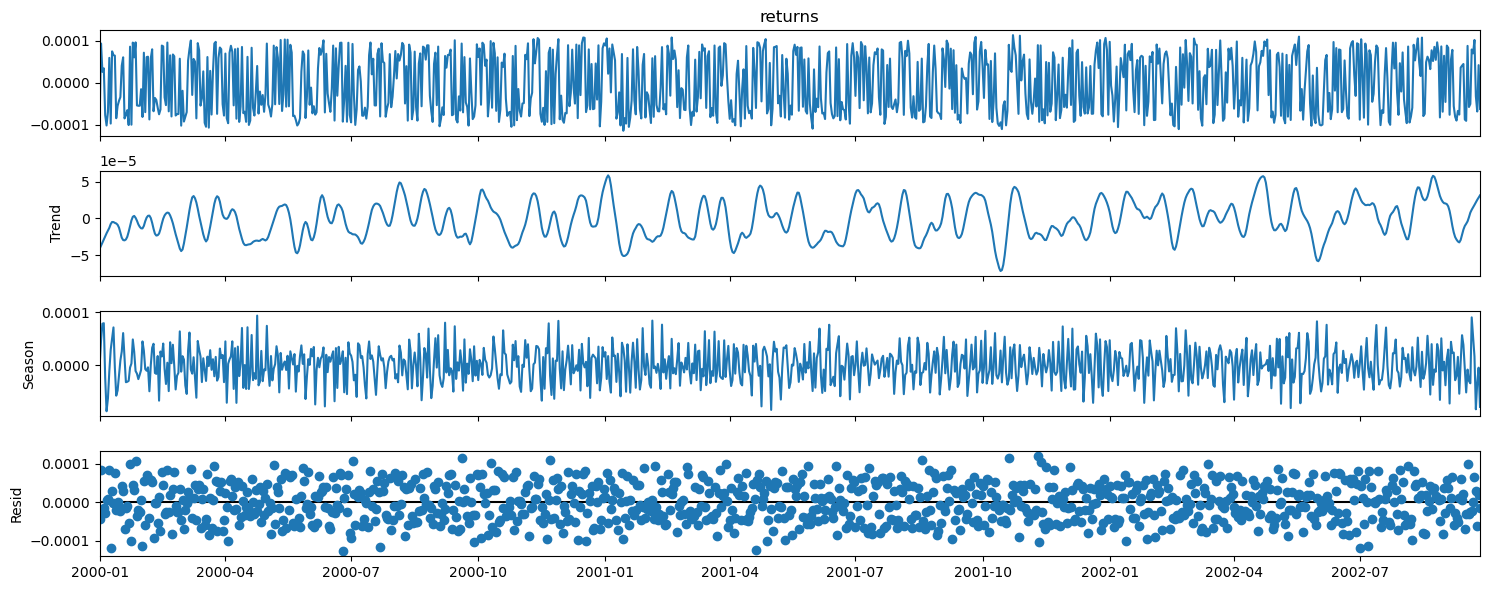

In [4]:
plt.rcParams['figure.figsize'] = (15, 6)

res = STL(returns).fit()
res.plot();

ADF Statistic: -29.524358
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


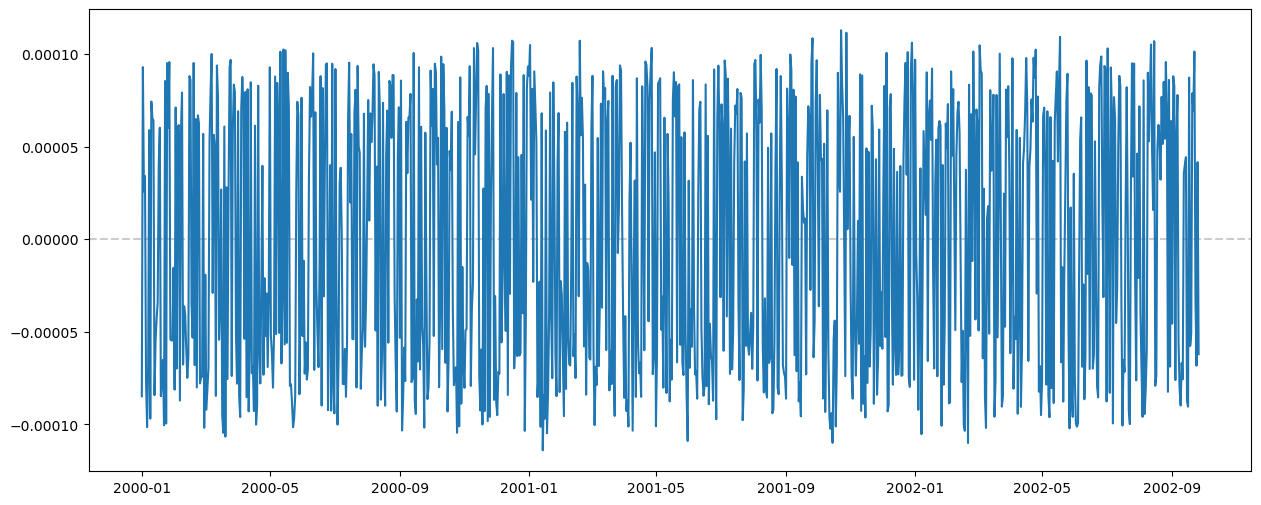

In [5]:
def adfuller_test_and_plot(series, first_100=True):
    len = 100 if first_100 else series.values.shape[0]
    slice = series[:len]

    adf = adfuller(slice)
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))

    plt.axhline(0, color='k', linestyle='--', alpha=.2)
    plt.plot(slice)

adfuller_test_and_plot(returns, False)

### Using the ADF (Augmented Dickey-Fuller) test we get a test statistic value of `-29.524358`. The more negative this statistic, the more likely we can reject the null hypothesis. As part of the output we also get a table to determine the ADF statistic. We see that statistic value of `-29.524358` is way below the value of `-3.437` at `1%`.

### That being said, it turns out that first-differencing would improve our ARIMA model performance below, so let's do it.

ADF Statistic: -5.273241
p-value: 0.000006
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


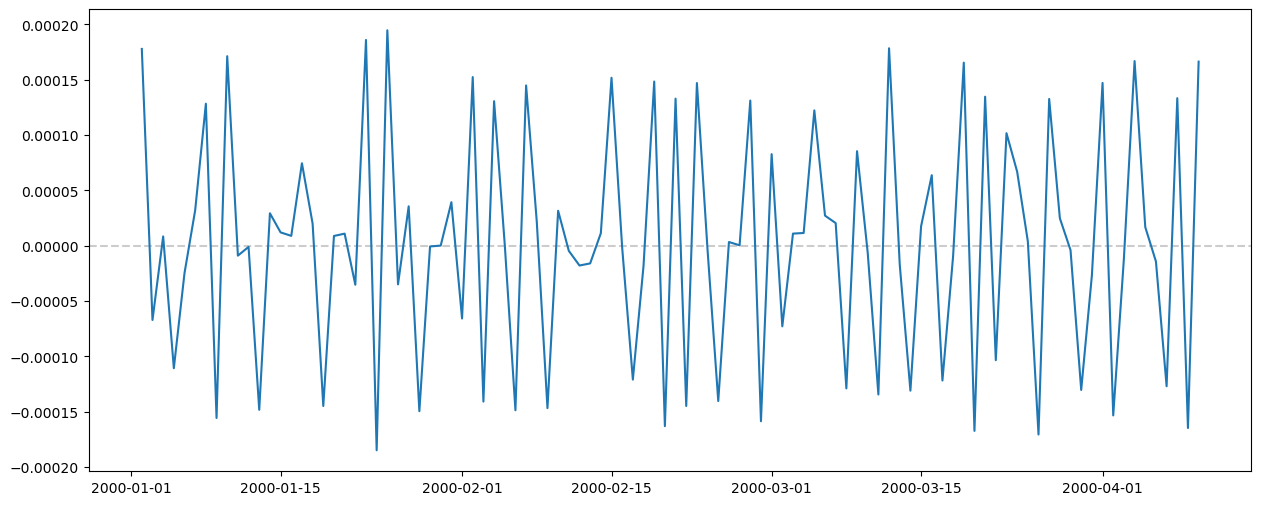

In [6]:
diff_returns = returns.diff().dropna()

adfuller_test_and_plot(diff_returns)

### And with that, we set the integrated part of the `ARIMA` model to `1`, that is the letter `I` by `ARIMA`.

### Let's plot [ACF](https://en.wikipedia.org/wiki/Autocorrelation) and [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function). The `ACF` gives a good hint about the `MA` part of the `ARIMA` model, the `PACF` on the other hand does the same job for the `AR` part.

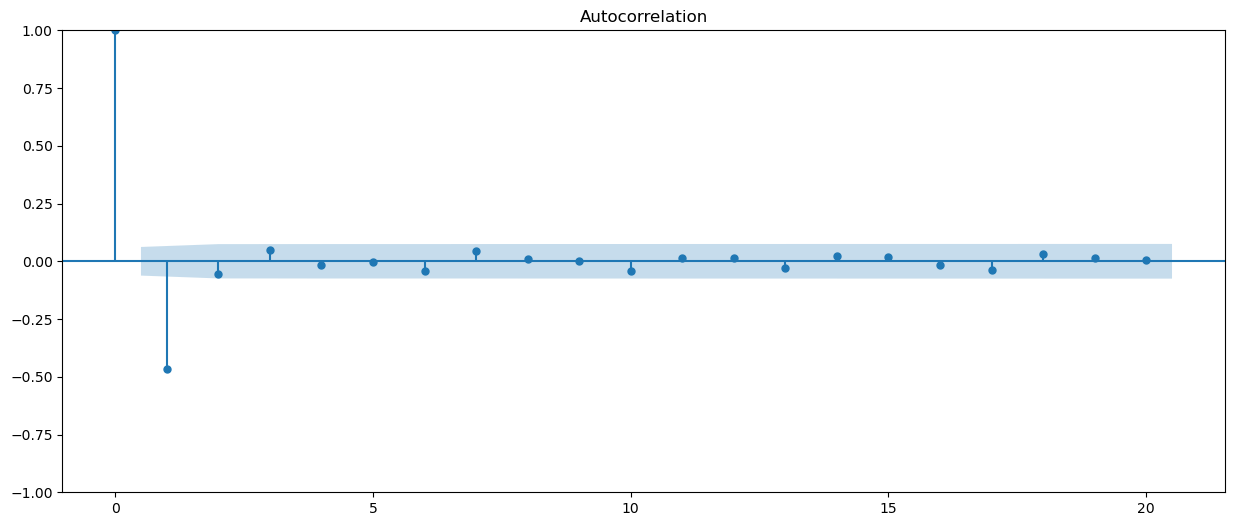

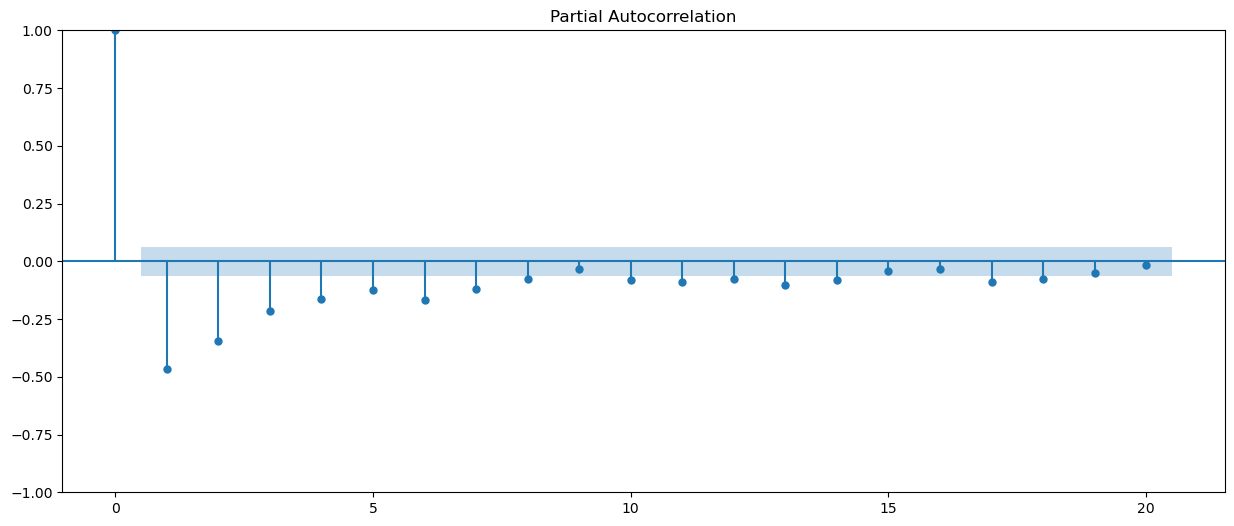

In [7]:
plot_acf(diff_returns, lags=20);
plot_pacf(diff_returns, lags=20);

### So we go for `p=20`, `d=1` and `q=1`. We use half of the data points for the training and the other half for testing.

In [8]:
import warnings

warnings.filterwarnings('ignore')

split_size = int(returns.size / 2)
train_data = returns[:split_size]
test_data = returns[split_size:]
returns_order = (20, 1, 1)

model = ARIMA(train_data, order=returns_order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                  500
Model:                ARIMA(20, 1, 1)   Log Likelihood                4014.953
Date:                Mon, 22 Jan 2024   AIC                          -7985.906
Time:                        16:54:28   BIC                          -7893.228
Sample:                    01-01-2000   HQIC                         -7949.536
                         - 05-14-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2526   2.08e-18  -1.21e+17      0.000      -0.253      -0.253
ar.L2         -0.3727   4.05e-19  -9.21e+17      0.000      -0.373      -0.373
ar.L3         -0.4813   1.56e-20  -3.08e+19      0.0

### Please note that all the p-values by the table above are below `.05%` meaning they're all significant and have a good predictive power. Now let's find out the optimal lag size using the cross-validation approach as described [here](https://otexts.com/fpp3/tscv.html).

In [9]:
def rolling_forecasting_origin(data, train_starting_size, arima_order):
    rolling_forecasts = data[train_starting_size:].copy()
    errors = []
    for train_end in rolling_forecasts.index:
        model = ARIMA(data[:train_end], order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast()
        rolling_forecasts[train_end] = forecast[0]
        errors.append(abs(forecast[0] - data[train_end]))
    return rolling_forecasts, pd.Series(errors)

In [10]:
train_starting_size = int(len(train_data)/2)
forecasts_length = len(train_data) - train_starting_size
column_labels = list(range(1, forecasts_length+1))
all_lag_forecasts = pd.DataFrame(columns=column_labels)
all_lag_errors = pd.DataFrame(columns=column_labels)

for lag in range(15, 21):
    try:
        forecasts, errors = rolling_forecasting_origin(train_data, train_starting_size, (lag, 1, 1))
        all_lag_forecasts.loc[lag] = forecasts.values
        all_lag_errors.loc[lag] = errors.values
    except Exception as e:
        print('the model with the lag of size: %d failed with the error message: %s' % (lag, e))
        continue

In [11]:
all_lag_forecasts

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
15,0.000143,0.000143,0.000103,0.000023,-0.000033,-0.000089,-0.000077,0.000021,-0.000024,-0.000009,...,0.000069,2.471849e-05,0.000022,-0.000005,0.000032,0.000053,0.000056,0.000032,0.000024,-0.000022
16,0.000145,0.000137,0.000098,0.000018,-0.000039,-0.000091,-0.000076,-0.000035,-0.000025,-0.000012,...,0.000068,7.006689e-06,0.000021,-0.000004,0.000025,0.000053,0.000056,0.000037,0.000032,-0.000022
17,0.000128,0.000131,0.000096,0.000021,-0.000017,-0.000065,-0.000064,-0.000030,-0.000035,-0.000021,...,0.000067,5.937535e-06,0.000014,-0.000030,0.000040,0.000045,0.000054,0.000037,0.000020,-0.000014
18,0.000132,0.000129,0.000103,0.000031,-0.000009,-0.000054,-0.000055,-0.000024,-0.000037,-0.000030,...,0.000063,6.166205e-06,0.000001,-0.000032,0.000027,0.000044,0.000032,0.000017,0.000023,-0.000035
19,0.000127,0.000135,0.000105,0.000040,0.000003,-0.000048,-0.000045,-0.000009,-0.000035,-0.000033,...,0.000068,3.228704e-06,0.000001,-0.000032,0.000023,0.000044,0.000035,0.000021,0.000022,-0.000038
20,0.000125,0.000135,0.000107,0.000042,0.000006,-0.000046,-0.000045,-0.000009,-0.000037,-0.000034,...,0.000066,-2.674948e-08,-0.000004,-0.000033,0.000023,0.000040,0.000036,0.000025,0.000028,-0.000038


In [12]:
all_lag_errors

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
15,0.000079,0.000108,0.000037,0.000043,0.000111,0.000012,0.000002,0.000080,0.000063,0.000086,...,0.000018,0.000074,0.000053,0.000076,0.000033,0.000075,0.000139,0.000025,2.942011e-06,0.000066
16,0.000081,0.000101,0.000033,0.000048,0.000117,0.000014,0.000001,0.000136,0.000062,0.000082,...,0.000019,0.000056,0.000052,0.000076,0.000041,0.000074,0.000139,0.000020,1.132815e-05,0.000066
17,0.000065,0.000096,0.000030,0.000045,0.000096,0.000012,0.000011,0.000131,0.000052,0.000074,...,0.000020,0.000055,0.000045,0.000051,0.000025,0.000067,0.000137,0.000020,9.479874e-07,0.000074
18,0.000068,0.000093,0.000037,0.000035,0.000087,0.000023,0.000021,0.000124,0.000050,0.000064,...,0.000024,0.000055,0.000032,0.000048,0.000039,0.000066,0.000115,0.000040,2.149261e-06,0.000053
19,0.000064,0.000099,0.000039,0.000026,0.000075,0.000029,0.000030,0.000110,0.000052,0.000061,...,0.000019,0.000052,0.000032,0.000049,0.000042,0.000066,0.000118,0.000036,8.780849e-07,0.000050
20,0.000062,0.000099,0.000041,0.000024,0.000073,0.000031,0.000030,0.000110,0.000050,0.000060,...,0.000021,0.000049,0.000027,0.000048,0.000043,0.000062,0.000119,0.000032,6.649408e-06,0.000050


In [13]:
errors_per_lag_size = all_lag_errors.sum(axis=1)
optimal_lag = errors_per_lag_size[errors_per_lag_size == errors_per_lag_size.min()].index[0]
print('the optimal lag size: %d ' % optimal_lag)

the optimal lag size: 18 


### Now using the rolling forecasting origin approach let's infer the unseen data (the second half of our data points) using the first half as the training set.

In [14]:
forecasts, _ = rolling_forecasting_origin(returns, len(train_data), (optimal_lag, 1, 1))

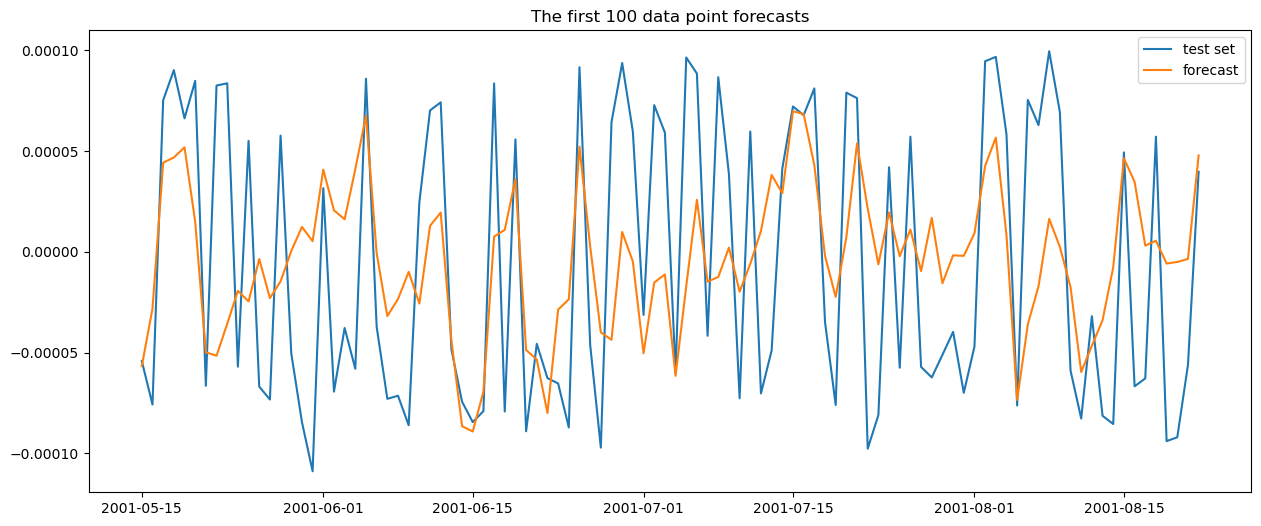

In [15]:
plt.plot(test_data[:100], label='test set')
plt.plot(forecasts[:100], label='forecast')
plt.title('The first 100 data point forecasts')
plt.legend()

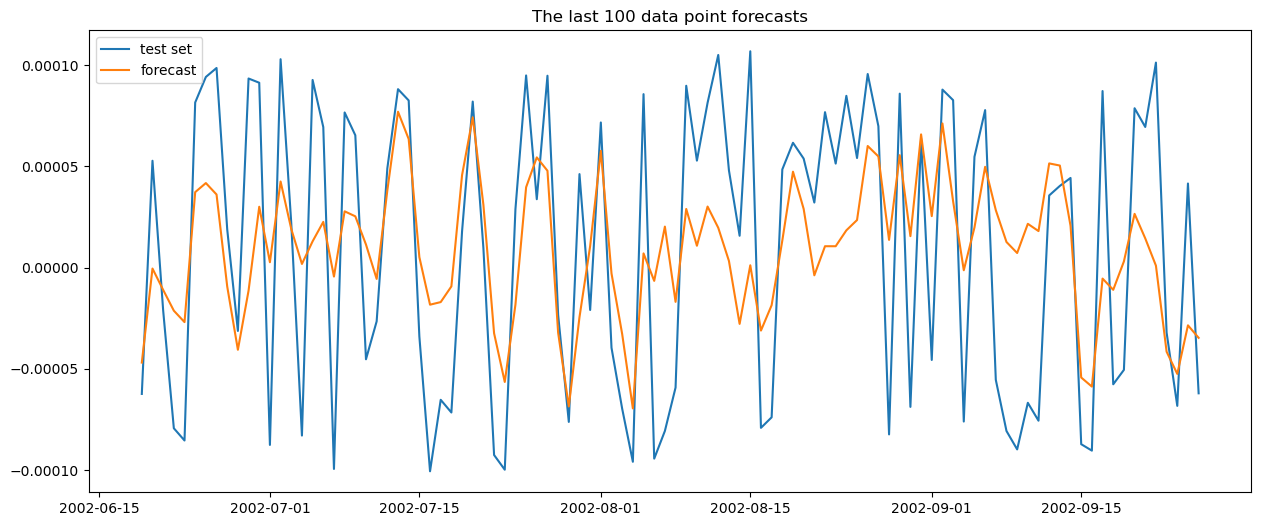

In [16]:
plt.plot(test_data[-100:], label='test set')
plt.plot(forecasts[-100:], label='forecast')
plt.title('The last 100 data point forecasts')
plt.legend()